In [14]:
import os
import numpy as np
from sklearn import metrics
from work_v2 import get_model, get_test_datagen, count_files
import itertools

In [10]:
def scores_from_model_top(group, position, model, top):
    weights_path = 'models/{group}/{position}/{model}/{top}/top_trained.h5'.format(position=position, group=group,
                                                                                   model=model, top=top)
    test_path = 'data/{position}_256/{group}/test/'.format(position=position, group=group)
    n_test_samples = count_files(test_path)
    n_steps_test = np.ceil(n_test_samples / batch_size)
    full_model = get_model(model, top)
    full_model.load_weights(weights_path)
    test_datagen = get_test_datagen(model)
    target_size = (224, 224)
    test_generator = test_datagen.flow_from_directory(
        test_path,
        # target_size=(224, 224),
        reader_config={'target_mode': 'RGB', 'target_size': target_size},
        batch_size=batch_size,
        shuffle=False)
    preds = full_model.predict_generator(
        generator=test_generator,
        steps=n_steps_test,
        workers=4,
        verbose=1)
    scores = preds[:, 1]
    return scores


def ensemble_roc_auc(y, scores, combination):
    ensemble_score = np.mean([scores[combination[0]], scores[combination[1]]], axis=0)
    fpr, tpr, thresholds = metrics.roc_curve(y, ensemble_score, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc


def ensemble_precision_recall(y, scores, combination):
    ensemble_score = np.mean([scores[combination[0]], scores[combination[1]]], axis=0)
    precision, recall, thresholds = metrics.precision_recall_curve(y, ensemble_score)
    return precision, recall, thresholds


In [11]:
def count_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
            cnt += len(glob.glob(os.path.join(r, dr + "/*")))
        return cnt


In [12]:
groups = ['M_Adult']
positions = ['PA', 'LAT']
models = ['resnet50', 'vgg16', 'vgg19']
tops = ['waya', 'chollet', 'linear']

In [16]:
batch_size = 32
scores = [scores_from_model_top(group, position, model, top) for group, position, model, top in
          itertools.product(groups, positions, models, tops)]
np.save('scores.npy', scores)
# num_files = sum(os.path.isfile(os.path.join(test_path, f)) for f in os.listdir(test_path))
# y = num_files/2 * [0] + num_files/2 * [1]
# combinations = [comb for comb in itertools.combinations(range(9), 2)]
# aucs = [ensemble_roc_auc(y, scores, comb) for comb in combinations]



Found 796 images belonging to 2 classes.
25/25 [==============================] - 10s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 10s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 10s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 14s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 14s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 14s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 17s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 17s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 17s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 11s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 11s    
Found 796 

TypeError: can't multiply sequence by non-int of type 'float'

In [19]:
scores_np = np.array(scores)

In [20]:
scores_np.shape

(18, 796)

In [59]:
comb_aucs = []
comb_precision = []
comb_recall = []
for i_group, group in enumerate(groups):
    for i_model, model in enumerate(models):
        test_path = 'data/PA_256/{group}/test/'.format(group=group)
        num_files = count_files(test_path)
#         num_files = sum(os.path.isfile(os.path.join(test_path, f)) for f in os.listdir(test_path))
        y = int(num_files / 2) * [0] + int(num_files / 2) * [1]
        for i_top, top in enumerate(tops):
            PA_model_score = scores_np[i_model*3+i_top,:]
            LAT_model_score = scores_np[9+i_model*3+i_top,:]
            ensemble_score = np.mean([PA_model_score, LAT_model_score], axis=0)
            fpr, tpr, thresholds = metrics.roc_curve(y, ensemble_score, pos_label=1)
            roc_auc = metrics.auc(fpr, tpr)
            comb_aucs.append(roc_auc)
            precision, recall, thresholds = metrics.precision_recall_curve(y, ensemble_score)
            comb_precision.append(precision)
            comb_recall.append(recall)
np.save('comb_aucs.npy', comb_aucs)
np.save('comb_precision.npy', comb_precision)
np.save('comb_recall.npy', comb_recall)

In [79]:
all_comb_auc = []
for PA_id, LAT_id in itertools.product(range(9), range(9,18)):
    PA_model_score = scores_np[PA_id, :]
    LAT_model_score = scores_np[LAT_id, :]
    ensemble_score = np.mean([PA_model_score, LAT_model_score], axis=0)
    fpr, tpr, thresholds = metrics.roc_curve(y, ensemble_score, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    all_comb_auc.append(roc_auc)
np.max(all_comb_auc)
np.argmax(all_comb_auc)

61

In [94]:
combs = [(i,j) for i,j in itertools.product(range(9), range(9,18))]
comb_names = [(m1, m2) for m1, m2 in itertools.product(models, tops)]
comb_names_sq = [(c1, c2) for c1, c2 in itertools.product(comb_names, comb_names)]

In [98]:
combs

[(0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (1, 17),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (3, 17),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (4, 15),
 (4, 16),
 (4, 17),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (5, 15),
 (5, 16),
 (5, 17),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (6, 15),
 (6, 16),
 (6, 17),
 (7, 9),
 (7, 10),
 (7, 11),
 (7, 12),
 (7, 13),
 (7, 14),
 (7, 15),
 (7, 16),
 (7, 17),
 (8, 9),
 (8, 10),
 (8, 11),
 (8, 12),
 (8, 13),
 (8, 14),
 (8, 15),
 (8, 16),
 (8, 17)]

In [97]:
comb_names_sq

[(('resnet50', 'waya'), ('resnet50', 'waya')),
 (('resnet50', 'waya'), ('resnet50', 'chollet')),
 (('resnet50', 'waya'), ('resnet50', 'linear')),
 (('resnet50', 'waya'), ('vgg16', 'waya')),
 (('resnet50', 'waya'), ('vgg16', 'chollet')),
 (('resnet50', 'waya'), ('vgg16', 'linear')),
 (('resnet50', 'waya'), ('vgg19', 'waya')),
 (('resnet50', 'waya'), ('vgg19', 'chollet')),
 (('resnet50', 'waya'), ('vgg19', 'linear')),
 (('resnet50', 'chollet'), ('resnet50', 'waya')),
 (('resnet50', 'chollet'), ('resnet50', 'chollet')),
 (('resnet50', 'chollet'), ('resnet50', 'linear')),
 (('resnet50', 'chollet'), ('vgg16', 'waya')),
 (('resnet50', 'chollet'), ('vgg16', 'chollet')),
 (('resnet50', 'chollet'), ('vgg16', 'linear')),
 (('resnet50', 'chollet'), ('vgg19', 'waya')),
 (('resnet50', 'chollet'), ('vgg19', 'chollet')),
 (('resnet50', 'chollet'), ('vgg19', 'linear')),
 (('resnet50', 'linear'), ('resnet50', 'waya')),
 (('resnet50', 'linear'), ('resnet50', 'chollet')),
 (('resnet50', 'linear'), ('resn

In [69]:
PA_model_score.shape

(796,)

In [70]:
LAT_model_score.shape

(796,)

In [71]:
inc_auc = []
for i in range(10):
    ensemble_score = np.mean([(i/10)*PA_model_score,(1-i/10)*LAT_model_score], axis=0)
    fpr, tpr, thresholds = metrics.roc_curve(y, ensemble_score, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    inc_auc.append(roc_auc)
inc_auc

[0.6172192621398449,
 0.63266079139415676,
 0.64783086285699865,
 0.66333552183025679,
 0.67675690007828082,
 0.68690815888487666,
 0.69211636069796212,
 0.69410494684477664,
 0.69341051993636516,
 0.69106209439155575]

In [72]:
import matplotlib.pyplot as plt

In [73]:
plt.plot(range(10), inc_auc)

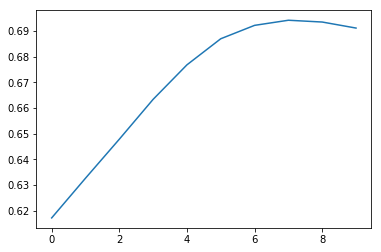

In [74]:
plt.show()

In [75]:
for i in range(9,18):
    print(i)

9
10
11
12
13
14
15
16
17
